## <span style="color:DarkGreen"> *10 Meter Wind Speed & Direction Comparison between Observations & The High Resolution Ensemble Forecast (HREF)* </span>
---

<div class="alert alert-block alert-success">
<b>Notes:</b> NONE!
</div>

#### **HREF Members Used:**

###### *- Advanced Research Weather (HRW WRF-ARW)*
###### *- Finite Volume Cubed Sphere (HRW WRF-FV3)*
###### *- National Severe Storms Laboratory (HRW WRF-NSSL)*
###### *- North American Model (NAM 3km CONUS)*
###### *- High Resolution Rapid Refresh (HRRR)*

#### **Observations Used:**
###### *- New York State Mesonet (NYSM)*
###### *- Automated Surface Observing Systems (ASOS)*

### Inputs

In [1]:
# HREF Initialization Time & NYSM Observation Starting Time
year = 2022 #2022
month = 2 #2
day = 17 #23
hour = 12 #6 
minute = 0 #0

# HREF Initialization Hour(s) (0, 6, 12, 18 UTC)
starthour = 16 # KEEP AT ZERO 
endhour = 16
inc = 1

### Imports

In [2]:
%matplotlib inline

# core
import os
import sys
import glob
import math
import cfgrib
import requests
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl

# Collections
from collections import Counter
from functools import reduce

# netCDF4
import netCDF4 as nc
from netCDF4 import Dataset

# datetime
import datetime as dt
from datetime import datetime,timedelta

#cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat 
from cartopy import feature as cfeature

# matplotlib
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.dates import DateFormatter, AutoDateLocator,HourLocator,DayLocator,MonthLocator

# metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot, USCOUNTIES
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components

### File Grabbing 

In [3]:
#Load in field sites
sites = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/nysm/site_locations.txt')

#Getting coordinates for mesonet data because 2022 files dont have them
fpath_coords = '/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2019/20190902.nc'

# ASOS File Grabbing 
df_NY = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_NY_ASOS.csv')
df_VT = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_VT_ASOS.csv')
df_QE = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_QE_ASOS.csv')
df_ON = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_ON_ASOS.csv')

# NYSM File Grabbing
hour_delta = 0
minute_delta = 15
year_str = str(year)
month_str = str(month).zfill(2)
day_str = str(day).zfill(2)
hour_str = str(hour).zfill(2)
day2_str = str(day+1)
base_dir = '/network/rit/lab/minderlab_rit/NYSM'
standard_dir = '/standard/netCDF/2022'
standard_1 = base_dir + standard_dir + '/' + year_str + month_str + day_str + '.nc'
standard_2 = base_dir + standard_dir + '/' + year_str + month_str + day2_str + '.nc'
print('We are using the following paths to grab NYSM data:')
print(standard_1)
print(standard_2)
print()
NYSM_temp = xr.open_mfdataset([standard_1,standard_2])
ds_coords = xr.open_dataset(fpath_coords)

####################################################################################
# HREF File Grabbing

href_base_dir = '/network/rit/lab/minderlab_rit/je845911/data/href'
yyyymmddhh_str = year_str + month_str + day_str + hour_str
yyyymmdd_str = yyyymmddhh_str[0:8]
yyyy_str = yyyymmddhh_str[0:4]
endhour = endhour +1
fhrs = np.arange(starthour,endhour,inc)
length = len(fhrs)
print(yyyymmddhh_str)

# ARW
arw = []
for fhr in fhrs:
    arw.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusarw_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2') # PROB WITH 0f0

# FV3
fv3 = []
for fhr in fhrs:
    fv3.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusfv3_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NSSL
nssl = []
for fhr in fhrs:
    nssl.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusnssl_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NCEP
ncep = []
for fhr in fhrs:
    ncep.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hrrr_ncep_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NAM
nam = []
for fhr in fhrs:
    nam.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

print("We are using the following paths to grab HREF data:")
for fpath in arw:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in fv3:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in nssl:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in ncep:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in nam:
    print(fpath)

We are using the following paths to grab NYSM data:
/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2022/20220217.nc
/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2022/20220218.nc

2022021712
We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hiresw_conusarw_2022021712f016.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hiresw_conusfv3_2022021712f016.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hiresw_conusnssl_2022021712f016.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hrrr_ncep_2022021712f016.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/nam_conusnest_2022021712f016.grib2


### NYSM Observations

In [4]:
# WINTRE-MIX REGION
latN = 46.5
latS = 44
lonW = -77.0
lonE = -72.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

# Making both files station coordinates formating identical
ds_coords['station']=np.array([str(stn.values,'utf-8') for stn in ds_coords['station']])

# Adding Lat and Lon from 2019 NYSM file to the 2022 Files 
NYSM_temp = NYSM_temp.assign(lat = ds_coords['lat'])
NYSM_temp = NYSM_temp.assign(lon = ds_coords['lon'])

# Converting NYSM .nc files to Pandas Dataframes
NYSM_temp = NYSM_temp.to_dataframe()
NYSM_temp = NYSM_temp.reset_index(level=1)

# Cropping the dataset to only get data from the WINTRE-MIX region
NYSM_temp_cropped = NYSM_temp[
    (NYSM_temp["lat"] <= latN) & 
    (NYSM_temp["lat"] >= latS) & 
    (NYSM_temp["lon"] >= lonW) & 
    (NYSM_temp["lon"] <= lonE)
]

# Storing cropped NYSM Temperature dataset as "NYSM_temp_cropped"
NYSM_temp_cropped = NYSM_temp_cropped[NYSM_temp_cropped['temp_2m'] != 'M']

# Making a time to move through NYSM Data
valid_time = datetime(year,month,day,hour,minute)
valid_time_str = valid_time.strftime("%Y-%m-%d %H:%M") 
hr = valid_time+dt.timedelta(minutes=minute_delta)
time = hr.strftime("%Y-%m-%d %H:%M") 

### ASOS Observations

In [5]:
dfs = [df_NY, df_ON, df_QE, df_VT] #Combining the ASOS dataframes from selected stations in Ontario, Quebec, and NY
df_merged = pd.concat(dfs)
df_merged_cropped = df_merged[
    (df_merged["lat"] <= latN) & 
    (df_merged["lat"] >= latS) & 
    (df_merged["lon"] >= lonW) & 
    (df_merged["lon"] <= lonE)
]

### 5 Pannel Output

MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to ESSX
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to WFMB
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to GABR
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to LOUI
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to ELLE
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to EDWA
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to PHIL
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to POTS
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to TUPP
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to CAPE
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to MALO
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to CHAZ
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to NHUD
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to HAMM
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint to SARA
MEAN 2022-02-18 04:00
Found the nearest HREF gridpoint 

/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(

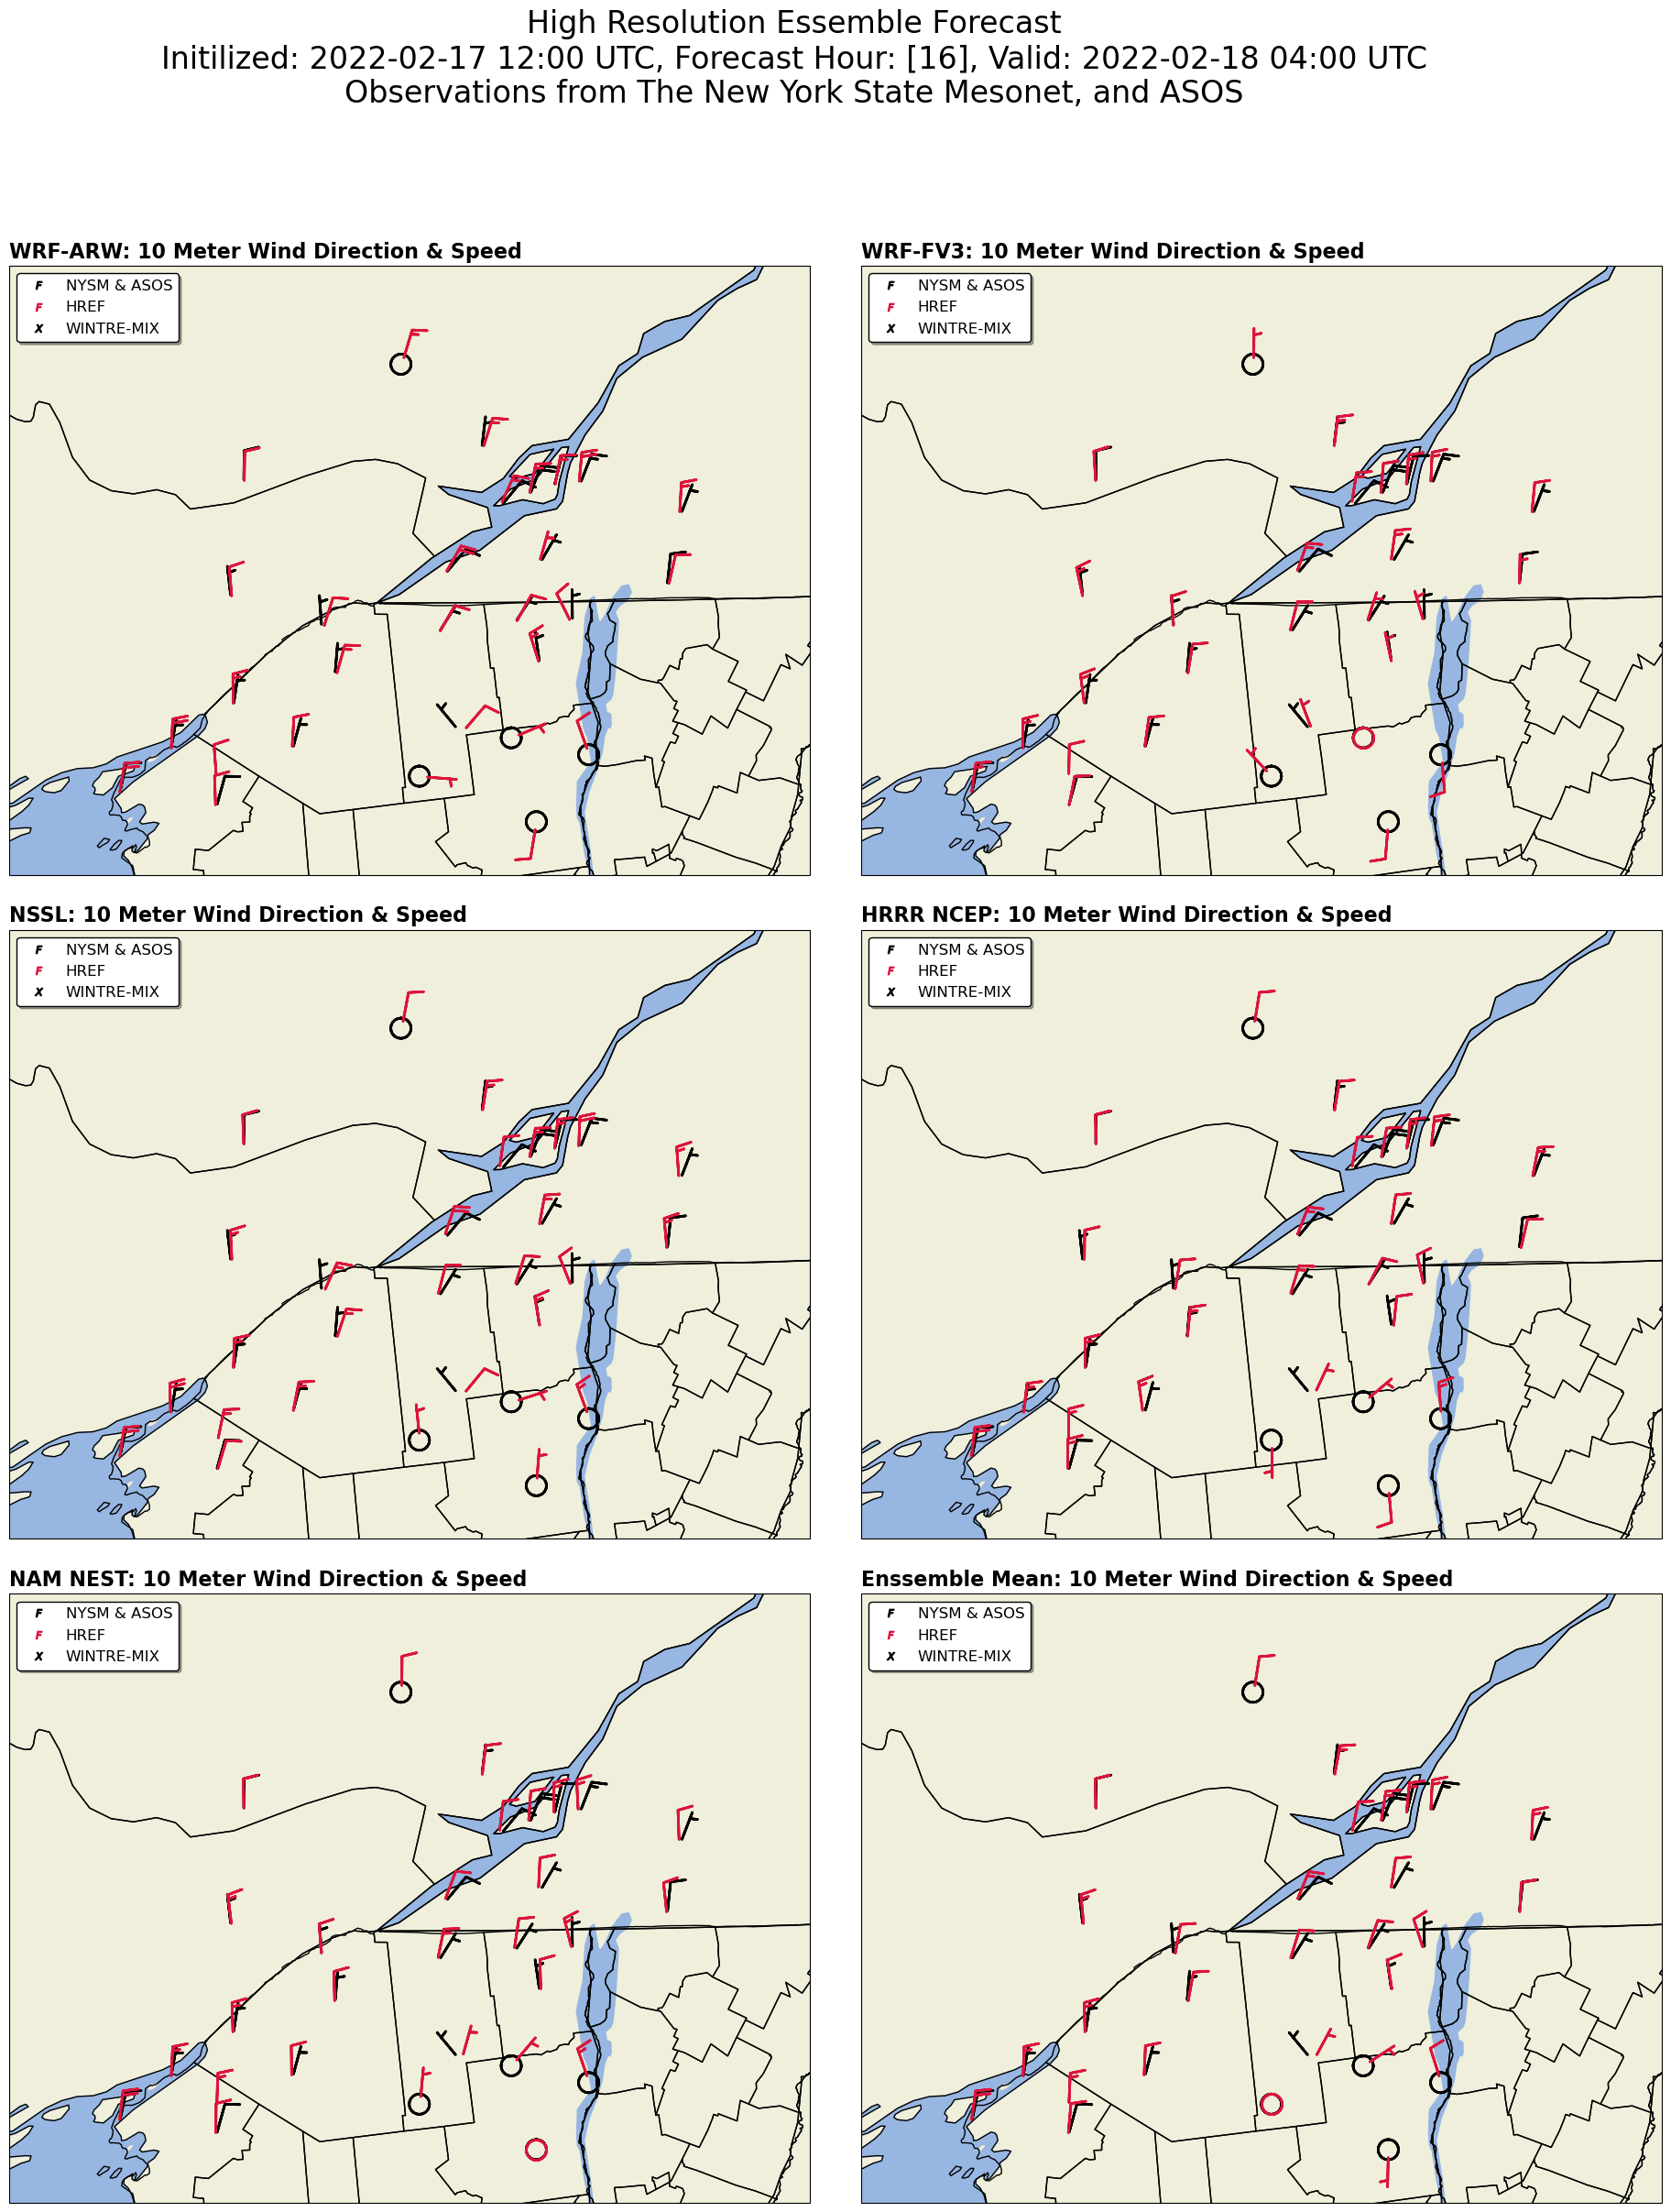

In [6]:
for i in fhrs:

    # Time 
    D = int(((i-starthour)/inc)) # Used for HREF File Reference  
    time = (hr) + timedelta(hours=float(i)) 
    adjtime = time - dt.timedelta(minutes=minute_delta)
    adjtimestr = adjtime.strftime("%Y-%m-%d %H:%M") 
    nysm_adjtime = time.strftime("%H:%M")
    time_delta = (hr) - timedelta(hours=hour_delta, minutes=minute_delta)
    time_delta_str = time_delta.strftime("%Y-%m-%d %H:%M") 
    titlestrend = adjtime.strftime("%Y-%m-%d %H:%M")


    # NYSM
    mask_NYSM_t = (NYSM_temp_cropped['time'] == time)
    NYSM_temp_mask = NYSM_temp_cropped.loc[mask_NYSM_t] 
    NYSM_temp_mask = NYSM_temp_mask.drop_duplicates(subset='lat', keep='last', inplace=False)
    NYSM_temp_lat = NYSM_temp_mask['lat']
    NYSM_temp_lon = NYSM_temp_mask['lon']
    WDir_NYSM = NYSM_temp_mask['wind_direction_sonic'].values.astype(float) * units.degrees
    WSpeed_NYSM = NYSM_temp_mask['avg_wind_speed_sonic'].values.astype(float) * units.knots
    u_NYSM, v_NYSM = mpcalc.wind_components(WSpeed_NYSM, WDir_NYSM)
    NYSM_stations = NYSM_temp_cropped.index.unique()
    NYSM_stations = NYSM_stations.to_list()
    
    # ASOS
    mask_ASOS = (df_merged_cropped['valid'] > time_delta_str) & (df_merged_cropped['valid'] <= adjtimestr)
    ASOS_cropped = df_merged_cropped.loc[mask_ASOS]
    df_merged = ASOS_cropped.drop_duplicates(subset='station', keep='last', inplace=False)   
    df_dropped_wind = df_merged[df_merged['mslp'] != 'M']
    df_dropped_wind = df_dropped_wind[df_dropped_wind['sknt'] != 'M']
    df_dropped_wind = df_dropped_wind[df_dropped_wind['drct'] != 'M']
    df_ASOS_station = df_dropped_wind.set_index('station')
    WDir_ASOS = df_dropped_wind['drct'].values.astype(float) * units.degrees
    WSpeed_ASOS = df_dropped_wind['sknt'].values.astype(float) * units.knots
    u_ASOS, v_ASOS = mpcalc.wind_components(WSpeed_ASOS, WDir_ASOS)
    lats_ASOS_wind = df_ASOS_station['lat']
    lons_ASOS_wind = df_ASOS_station['lon']
    ASOS_stations = df_dropped_wind['station'].to_list()
    lats_wind = pd.concat([NYSM_temp_lat, lats_ASOS_wind])
    lons_wind = pd.concat([NYSM_temp_lon, lons_ASOS_wind])
    stations = NYSM_stations + ASOS_stations
    
    #Get nearest gridpoint to station lat/lon
    def get_nearest_gridpoint(xlat, xlong, slat, slon, verbose = False):
        abslat = np.fabs(xlat-slat)
        abslon = np.fabs(xlong-slon)
        c = np.maximum(abslon, abslat)
        xyloc = np.where(c == np.min(c))
        xs, ys = xyloc[1][0], xyloc[0][0]
        return (xs, ys)

        # Defiining Figure Features
    def features(ax):
        ax.set_extent ([lonW,lonE,latS,latN])
        ax.add_feature (cfeature.LAND.with_scale(res), zorder=1)
        ax.add_feature (cfeature.OCEAN.with_scale(res), zorder=1)
        ax.add_feature (cfeature.LAKES.with_scale(res), zorder=1)
        ax.add_feature(cfeature.COASTLINE.with_scale(res), zorder = 3)
        ax.add_feature (cfeature.STATES.with_scale(res), zorder = 3)
        ax.add_feature(USCOUNTIES.with_scale(county_scale),zorder= 3, linewidth = county_lw)
        
    def legend(ax):
        HREF = mlines.Line2D([], [], color=c, marker='$F$', ls='', label='HREF', markeredgecolor='crimson')
        NYSM = mlines.Line2D([], [], color=c, marker='$F$', ls='', label='NYSM & ASOS', markeredgecolor=color)
        WINTRE_MIX = mlines.Line2D([], [], color=c, marker='$X$', ls='', label='WINTRE-MIX', markeredgecolor=color)
        ax.legend(loc = 'upper left',handles=[NYSM, HREF, WINTRE_MIX],frameon=True,fontsize=12,shadow = True,edgecolor = 'black')
        
    # Title
    tl0 = 'High Resolution Essemble Forecast'
    tl1 = 'Observations from The New York State Mesonet, and ASOS'
    tl2 = f'Initilized: {valid_time_str} UTC, Forecast Hour: [{i}], Valid: {titlestrend} UTC'

    title_line = (tl0+ '\n' + tl2 + '\n' + tl1)
    
    model1_t = 'WRF-ARW: 10 Meter Wind Direction & Speed'
    model2_t = 'WRF-FV3: 10 Meter Wind Direction & Speed'
    model3_t = 'NSSL: 10 Meter Wind Direction & Speed'
    model4_t = 'HRRR NCEP: 10 Meter Wind Direction & Speed'
    model5_t = 'NAM NEST: 10 Meter Wind Direction & Speed'
    model6_t = 'Enssemble Mean: 10 Meter Wind Direction & Speed'

    titletime = valid_time.strftime("%Y%m%d%H") 
    savefiguretitle = f'5_panel_wind_{str(titletime)}_{i}'

    # Expanded WINTRE-MIX region

    latN = 46.5
    latS = 43.75
    lonW = -77.0
    lonE = -72.0
    cLat = (latN + latS)/2
    cLon = (lonW + lonE )/2
    
    # ASOS & NYSM Features
    c='white'
    color ='black'
    fontsize = 12
    barbcolor = 'crimson'
    barbsize = 12
    barbwidth  = 2
    county_lw, county_scale = 1.0, '5m'
    
    # Figure Features
    res = '50m'
    proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
    msize = 110
    
    # Surface Temperature Figure
    fig = plt.figure(figsize=(36,28),dpi=100) # 36,28
    fig.suptitle(title_line, fontsize = 24)
    plt.subplots_adjust(hspace = 0.09)
    plt.subplots_adjust(wspace = -0.5)

    ax1 = fig.add_subplot(3,2,1, projection=proj)
    ax1.set_title(model1_t,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax1)    
    ax1.scatter(sites['lon'], sites['lat'], s = msize, c = 'black', marker = "$X$" , transform = ccrs.PlateCarree(), zorder = 4, label= 'WINTRE-MIX Sites')    
    stationplot_NYSM = StationPlot(ax1, NYSM_temp_lon, NYSM_temp_lat, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_NYSM.plot_barb(u_NYSM, v_NYSM) 
    stationplot_ASOS = StationPlot(ax1, lons_ASOS_wind, lats_ASOS_wind, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_ASOS.plot_barb(u_ASOS, v_ASOS)
    legend(ax1)
    
    ax2 = fig.add_subplot(3,2,2, projection=proj)
    ax2.set_title(model2_t,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax2)    
    ax2.scatter(sites['lon'], sites['lat'], s = msize, c = 'black', marker = "$X$" , transform = ccrs.PlateCarree(), zorder = 4, label= 'WINTRE-MIX Sites')
    stationplot_NYSM = StationPlot(ax2, NYSM_temp_lon, NYSM_temp_lat, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_NYSM.plot_barb(u_NYSM, v_NYSM)
    stationplot_ASOS = StationPlot(ax2, lons_ASOS_wind, lats_ASOS_wind, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_ASOS.plot_barb(u_ASOS, v_ASOS) 
    legend(ax2)
    
    ax3 = fig.add_subplot(3,2,3, projection=proj)
    ax3.set_title(model3_t,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax3)
    ax3.scatter(sites['lon'], sites['lat'], s = msize, c = 'black', marker = "$X$" , transform = ccrs.PlateCarree(), zorder = 4, label= 'WINTRE-MIX Sites') 
    stationplot_NYSM = StationPlot(ax3, NYSM_temp_lon, NYSM_temp_lat, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_NYSM.plot_barb(u_NYSM, v_NYSM) 
    stationplot_ASOS = StationPlot(ax3, lons_ASOS_wind, lats_ASOS_wind, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_ASOS.plot_barb(u_ASOS, v_ASOS)
    legend(ax3)
    
    ax4 = fig.add_subplot(3,2,4, projection=proj)
    title = ax4.set_title(model4_t,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax4)  
    ax4.scatter(sites['lon'], sites['lat'], s = msize, c = 'black', marker = "$X$" , transform = ccrs.PlateCarree(), zorder = 4, label= 'WINTRE-MIX Sites')   
    stationplot_NYSM = StationPlot(ax4, NYSM_temp_lon, NYSM_temp_lat, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_NYSM.plot_barb(u_NYSM, v_NYSM) 
    stationplot_ASOS = StationPlot(ax4, lons_ASOS_wind, lats_ASOS_wind, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_ASOS.plot_barb(u_ASOS, v_ASOS)
    legend(ax4)
    
    ax5 = fig.add_subplot(3,2,5, projection=proj)
    ax5.set_title(model5_t,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax5)   
    ax5.scatter(sites['lon'], sites['lat'], s = msize, c = 'black', marker = "$X$" , transform = ccrs.PlateCarree(), zorder = 4, label= 'WINTRE-MIX Sites')  
    stationplot_NYSM = StationPlot(ax5, NYSM_temp_lon, NYSM_temp_lat, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_NYSM.plot_barb(u_NYSM, v_NYSM) 
    stationplot_ASOS = StationPlot(ax5, lons_ASOS_wind, lats_ASOS_wind, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_ASOS.plot_barb(u_ASOS, v_ASOS)
    legend(ax5)
    
    ax6 = fig.add_subplot(3,2,6, projection=proj)
    ax6.set_title(model6_t,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax6)   
    ax6.scatter(sites['lon'], sites['lat'], s = msize, c = 'black', marker = "$X$" , transform = ccrs.PlateCarree(), zorder = 4, label= 'WINTRE-MIX Sites')  
    stationplot_NYSM = StationPlot(ax6, NYSM_temp_lon, NYSM_temp_lat, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_NYSM.plot_barb(u_NYSM, v_NYSM) 
    stationplot_ASOS = StationPlot(ax6, lons_ASOS_wind, lats_ASOS_wind, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    stationplot_ASOS.plot_barb(u_ASOS, v_ASOS)
    legend(ax6)
    
    # Standard Deviation Figure
    #fig = plt.figure(figsize=(11.25,11.25),dpi=100)
    #ax0 = fig.add_subplot(1,1,1, projection=proj)
    #ax0.set_title(model6_t + variable,fontsize=16,fontweight = 'bold',loc = 'left')
    #features(ax0)   
    #ax0.scatter(sites['lon'], sites['lat'], s = msize, c = 'black', marker = "$X$" , transform = ccrs.PlateCarree(), zorder = 4, label= 'WINTRE-MIX Sites')  
    #stationplot_NYSM = StationPlot(ax0, NYSM_temp_lon, NYSM_temp_lat, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    #stationplot_NYSM.plot_barb(u_NYSM, v_NYSM) 
    #stationplot_ASOS = StationPlot(ax0, lons_ASOS_wind, lats_ASOS_wind, transform=ccrs.PlateCarree(), zorder=5, fontsize=barbsize, linewidth=barbwidth)
    #stationplot_ASOS.plot_barb(u_ASOS, v_ASOS)
        
    for x in stations:
        
        station_lat = lats_wind[x]
        station_lon = 360 + lons_wind[x]

        # ARW U-wind 
        with xr.open_mfdataset(arw[D], engine = 'cfgrib',
                             filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},
                             concat_dim = 'valid_time',combine = 'nested') as arw_u10:
            arw_u10m = arw_u10['u10']*1.94384 #m s^-1 to knots

        # ARW V-wind
        with xr.open_mfdataset(arw[D], engine = 'cfgrib',
                             filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},
                             concat_dim = 'valid_time',combine = 'nested') as arw_v10:
            arw_v10m = arw_v10['v10']*1.94384 #m s^-1 to knots
            
        # FV3 U-wind 
        with xr.open_mfdataset(fv3[D], engine = 'cfgrib',
                             filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},
                             concat_dim = 'valid_time',combine = 'nested') as fv3_u10:
            fv3_u10m = fv3_u10['u10']*1.94384 #m s^-1 to knots

        # FV3 V-wind
        with xr.open_mfdataset(fv3[D], engine = 'cfgrib',
                             filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},
                             concat_dim = 'valid_time',combine = 'nested') as fv3_v10:
            fv3_v10m = fv3_v10['v10']*1.94384 #m s^-1 to knots
            
        # NSSL U-wind
        with xr.open_mfdataset(nssl[D], engine = 'cfgrib',
                             filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},
                             concat_dim = 'valid_time',combine = 'nested') as nssl_u10:
            nssl_u10m = nssl_u10['u10']*1.94384 #m s^-1 to knots
            
        # NSSL V-wind
        with xr.open_mfdataset(nssl[D], engine = 'cfgrib',
                             filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},
                             concat_dim = 'valid_time',combine = 'nested') as nssl_v10:
            nssl_v10m = nssl_v10['v10']*1.94384 #m s^-1 to knots
            
        # NCEP U-wind
        with xr.open_mfdataset(ncep[D], engine = 'cfgrib',
                             filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},
                             concat_dim = 'valid_time',combine = 'nested') as ncep_u10:
            ncep_u10m = ncep_u10['u10']*1.94384 #m s^-1 to knots
            
        # NCEP V-wind
        with xr.open_mfdataset(ncep[D], engine = 'cfgrib',
                             filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},
                             concat_dim = 'valid_time',combine = 'nested') as ncep_v10:
            ncep_v10m = ncep_v10['v10']*1.94384 #m s^-1 to knots
            
        # NAM V-wind
        with xr.open_mfdataset(nam[D], engine = 'cfgrib',
                             filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},
                             concat_dim = 'valid_time',combine = 'nested') as nam_u10:
            nam_u10m = nam_u10['u10']*1.94384 #m s^-1 to knots
            
        # NAM V-wind
        with xr.open_mfdataset(nam[D], engine = 'cfgrib',
                             filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},
                             concat_dim = 'valid_time',combine = 'nested') as nam_v10:
            nam_v10m = nam_v10['v10']*1.94384 #m s^-1 to knots
        
        # Enssemble Mean
        u_wind_ens = []
        v_wind_ens = []
        u_wind_ens.append(arw_u10m)
        u_wind_ens.append(fv3_u10m)
        u_wind_ens.append(nssl_u10m)
        u_wind_ens.append(ncep_u10m)
        u_wind_ens.append(nam_u10m)
        v_wind_ens.append(arw_v10m)
        v_wind_ens.append(fv3_v10m)
        v_wind_ens.append(nssl_v10m)
        v_wind_ens.append(ncep_v10m)
        v_wind_ens.append(nam_v10m)
        u_wind_ens = xr.concat(u_wind_ens, dim = 'ens')
        v_wind_ens = xr.concat(v_wind_ens, dim = 'ens')
        u_wind_mean = u_wind_ens.mean(dim = 'ens')
        v_wind_mean = v_wind_ens.mean(dim = 'ens')
        u_wind_std = u_wind_ens.std(dim = 'ens')
        v_wind_std = v_wind_ens.std(dim = 'ens')
        print('MEAN',adjtimestr)
    
    
        gridpoints = get_nearest_gridpoint(arw_v10m['latitude'],arw_u10m['longitude'],station_lat,station_lon, verbose = True)# CHAZY
        station_x = gridpoints[0]
        station_y = gridpoints[1]
        print("Found the nearest HREF gridpoint to " + x)

        # Selecting Location for wind barbs and converting units
        arw_uw = arw_u10m.sel(y = station_y , x = station_x).values
        arw_uw = np.float32(arw_uw) * units.knots
        arw_vw = arw_v10m.sel(y = station_y , x = station_x).values
        arw_vw = np.float32(arw_vw) * units.knots
        fv3_uw = fv3_u10m.sel(y = station_y , x = station_x).values
        fv3_uw = np.float32(fv3_uw) * units.knots
        fv3_vw = fv3_v10m.sel(y = station_y , x = station_x).values
        fv3_vw = np.float32(fv3_vw) * units.knots
        nssl_uw = nssl_u10m.sel(y = station_y , x = station_x).values
        nssl_uw = np.float32(nssl_uw) * units.knots
        nssl_vw = nssl_v10m.sel(y = station_y , x = station_x).values
        nssl_vw = np.float32(nssl_vw) * units.knots
        ncep_uw = ncep_u10m.sel(y = station_y , x = station_x).values
        ncep_uw = np.float32(ncep_uw) * units.knots
        ncep_vw = ncep_v10m.sel(y = station_y , x = station_x).values
        ncep_vw = np.float32(ncep_vw) * units.knots
        nam_uw = nam_u10m.sel(y = station_y , x = station_x).values
        nam_uw = np.float32(nam_uw) * units.knots
        nam_vw = nam_v10m.sel(y = station_y , x = station_x).values
        nam_vw = np.float32(nam_vw) * units.knots
        mean_uw = u_wind_mean.sel(y = station_y , x = station_x).values
        mean_uw = np.float32(mean_uw) * units.knots
        mean_vw = v_wind_mean.sel(y = station_y , x = station_x).values
        mean_vw = np.float32(mean_vw) * units.knots
        std_uw = u_wind_std.sel(y = station_y , x = station_x).values
        std_uw = np.float32(std_uw) * units.knots
        std_vw = v_wind_std.sel(y = station_y , x = station_x).values
        std_vw = np.float32(std_vw) * units.knots

        
        # Plotting HREF Winds at NYSM & ASOS station locations
        stationplot_arw = StationPlot(ax1, station_lon, station_lat, transform=ccrs.PlateCarree(), color=barbcolor, zorder=6, fontsize=barbsize, linewidth=barbwidth)
        stationplot_arw.plot_barb(arw_uw, arw_vw) # zorder value set so wind barbs will 
        stationplot_fv3 = StationPlot(ax2, station_lon, station_lat, transform=ccrs.PlateCarree(), color=barbcolor, zorder=6, fontsize=barbsize, linewidth=barbwidth)
        stationplot_fv3.plot_barb(fv3_uw, fv3_vw) # zorder value set so wind barbs will 
        stationplot_nssl = StationPlot(ax3, station_lon, station_lat, transform=ccrs.PlateCarree(), color=barbcolor, zorder=6, fontsize=barbsize, linewidth=barbwidth)
        stationplot_nssl.plot_barb(nssl_uw, nssl_vw) # zorder value set so wind barbs will 
        stationplot_ncep = StationPlot(ax4, station_lon, station_lat, transform=ccrs.PlateCarree(), color=barbcolor, zorder=6, fontsize=barbsize, linewidth=barbwidth)
        stationplot_ncep.plot_barb(ncep_uw, ncep_vw) # zorder value set so wind barbs will 
        stationplot_nam = StationPlot(ax5, station_lon, station_lat, transform=ccrs.PlateCarree(), color=barbcolor, zorder=6, fontsize=barbsize, linewidth=barbwidth)
        stationplot_nam.plot_barb(nam_uw, nam_vw) # zorder value set so wind barbs will 
        stationplot_mean = StationPlot(ax6, station_lon, station_lat, transform=ccrs.PlateCarree(), color=barbcolor, zorder=6, fontsize=barbsize, linewidth=barbwidth)
        stationplot_mean.plot_barb(mean_uw, mean_vw) # zorder value set so wind barbs will 
        #stationplot_std = StationPlot(ax0, station_lon, station_lat, transform=ccrs.PlateCarree(), color=barbcolor, zorder=6, fontsize=barbsize, linewidth=barbwidth)
        #stationplot_std.plot_barb(std_uw, std_vw) # zorder value set so wind barbs will 
    
    fig.savefig(savefiguretitle)

England, John | 07/01/2022